<div style="border-radius: 20px; border:#9B8BA8 solid; padding: 15px; background-color: #E6E6FA; font-size:130%; text-align:center">

# **A/B Testi**







<div style="border-radius:1px; border:#9B8BA8 solid; padding: 15px; background-color: #E6E6FA; font-size:110%; text-align:left">
    
    
*21.yüzyıl ile gelişen teknoloji ile bereber kullanıcı sayısının artmıstır. Artan kullanıcı sayısı ile birlikte dijital rekabet ortamı oluşmuştur. Bu durumda düşük maliyet ve eş zamnalı veri akısı sağlayabilen A/B testleri giderek önem kazanmıştır. 
    A/B testi iki veya daha fazla grubun karşıştırmasının sonucunda hangisinin en iyi performansa sahip olduğunu belirleyen ölçüm yöntemidir. Bu ölçüm yöntemi sonucunda veriler arasında İstatistiksel olarak anlamlı bir karşılaştırma yapılabilir.*
    

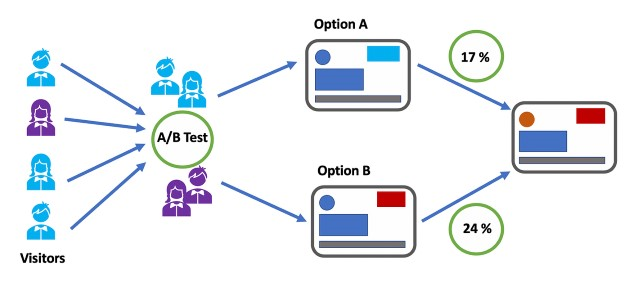

<div style="border-radius:1px; border:#9B8BA8 solid; padding: 15px; background-color: #E6E6FA; font-size:100%; text-align:left">

# Veri    
    
USER_ID: Kullanıcı numarası

VARIANT_NAME: Grup Üyeliği

REVENUE: Gelir

#  Kütüphane İçe Aktarma (Imports)

In [1]:
#KÜTÜPHANELER
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install statsmodels
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
#VERİ OKUMA
df = pd.read_csv("/kaggle/input/ab-test-data/AB_Test_Results.csv")
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.00000
1,2423,control,0.00000
2,9411,control,0.00000
3,7311,control,0.00000
4,6174,variant,0.00000


In [5]:
df.sort_values(by="REVENUE", ascending=False).head(15)


,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01000
6447,2881,variant,58.63000
7642,7206,variant,57.46000
9421,6792,control,41.53000
8168,2166,control,29.32000
...,...,...,...
1388,7358,control,17.87000
3218,701,control,17.08000
758,4445,control,17.05000
4031,2059,control,14.24000


In [6]:
def check_df(dataframe, head=5):
    print("---------------------- Shape ----------------------")
    print(dataframe.shape)
    print("---------------------- Types -----------------------")
    print(dataframe.dtypes)
    print("---------------------- Head ------------------------")
    print(dataframe.head())
    print("---------------------- Tail ------------------------")
    print(dataframe.tail())
    print("---------------------- NA---------------------------")
    print(dataframe.isnull().sum())
    print("--------------------- describe ---------------------")
    print(dataframe.describe().T)

check_df(df)

---------------------- Shape ----------------------
(10000, 3)
---------------------- Types -----------------------
USER_ID           int64
VARIANT_NAME     object
REVENUE         float64
dtype: object
---------------------- Head ------------------------
   USER_ID VARIANT_NAME  REVENUE
0      737      variant  0.00000
1     2423      control  0.00000
2     9411      control  0.00000
3     7311      control  0.00000
4     6174      variant  0.00000
---------------------- Tail ------------------------
      USER_ID VARIANT_NAME  REVENUE
9995     1981      control  0.00000
9996      502      variant  0.00000
9997     9214      variant  0.00000
9998     7741      control  0.00000
9999     9468      control  0.00000
---------------------- NA---------------------------
USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64
--------------------- describe ---------------------
              count       mean        std     min        25%        50%  \
USER_ID 10000.00000 4981.08020

# Değişken Tanımlama

In [7]:
control = df.loc[df["VARIANT_NAME"]=="control"]
control.sort_values(by="REVENUE", ascending=False).head(5)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01000
9421,6792,control,41.53000
8168,2166,control,29.32000
9125,831,control,25.98000
6412,1053,control,20.07000


In [8]:
variant = df.loc[df["VARIANT_NAME"]=="variant"]
variant.sort_values(by="REVENUE", ascending=False).head(5)

,USER_ID,VARIANT_NAME,REVENUE
6447,2881,variant,58.63000
7642,7206,variant,57.46000
2482,7356,variant,23.04000
5217,3684,variant,19.47000
5212,6294,variant,12.99000


<div style="border-radius:1px; border:#9B8BA8 solid; padding: 15px; background-color: #E6E6FA; font-size:110%; text-align:left">
    
# Hipotez oluşturma
    
*     H0: μ1 = μ2 (Kontrol ve test verileri setlerinin REVENUE Ort. Arasında istatiksel olarak Anlamlı Fark Yoktur)
    
    
*     H1: μ1 != μ2 ( .... vardır.)

In [9]:
print(control["REVENUE"].mean())

print(variant["REVENUE"].mean())

0.12901284109149277
0.07006977671451356


<div style="border-radius:1px; border:#9B8BA8 solid; padding: 15px; background-color: #E6E6FA; font-size:110%; text-align:left">
    
# Varyans Kontrolü
* Normallik Varyansı(Shapiro Wilk Testi):
    
    H0: Normal dağılım varsayımı sağlanmaktadır.
    
    H1: Normal dağılım varsayımı sağlanmamaktadır.
    
    p < 0.05 H0 RED 
    p > 0.05 H0 REDDEDİLEMEZ
    

    
* Varyans Homojenliği:
    
    H0: Grupların varyansları homojendir
    
    H1: Grupların varyansları homojen değildir
    
    p < 0.05 H0 RED 
    p > 0.05 H0 REDDEDİLEMEZ
    
    
    
*Varyans kontrolünde p-value değerleri 0.05'den küçük olduğu için H0 değeri red edilir.*


In [10]:
test_stat, pvalue = shapiro(control["REVENUE"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.0183, p-value = 0.0000


In [11]:
test_stat, pvalue = shapiro(variant["REVENUE"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.0270, p-value = 0.0000


/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


<div style="border-radius:1px; border:#9B8BA8 solid; padding: 15px; background-color: #E6E6FA; font-size:110%; text-align:left">
    

   

# Hipotezin Uygulanması
*     Parametrik Test : Varyasımlar sağlanmıyorsa bağımsız iki örneklem T testi
*     Non-parametrik Test : Varyanslar sağlanmıyorsa mamwhitneyu testi
    
    
*V arsayımlar sağlanmasığı için mannwhitneyu testi(non-parametrik test) kullanılır.*

In [12]:
test_stat, pvalue = mannwhitneyu(variant["REVENUE"].dropna(),
                                 control["REVENUE"].dropna())
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 12478180.0000, p-value = 0.4783


<div style="border-radius:1px; border:#9B8BA8 solid; padding: 15px; background-color: #E6E6FA; font-size:110%; text-align:left">
    

# Yorum

  *p-value değeri 0.05'den büyük olduğu için H0 red edilmez yani kontrol ve test verilerinin REVENUE Ort. Arasında istatiksel olarak Anlamlı Fark Yoktur*
    
